In [19]:
import ee
import ee
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import requests

ee.Authenticate()
ee.Initialize()


In [23]:

# Define Region (Example: Lahore, Pakistan)
region = ee.Geometry.Rectangle([74.30, 31.45, 74.40, 31.55])  # Define bounding box

# Define Date Range
start_date = '2025-01-01'
end_date = '2025-01-31'



In [34]:
import ee
import numpy as np
import cv2
import requests
import tempfile
from sklearn.model_selection import train_test_split
import tensorflow as tf



# Fetch Sentinel-2 Images
sentinel2_dataset = ee.ImageCollection("COPERNICUS/S2") \
    .filterDate(start_date, end_date) \
    .filterBounds(region) \
    .select(['B4', 'B3', 'B2'])  # RGB bands

# Convert Images to NumPy Arrays
def get_sentinel2_array(image):
    url = image.getThumbUrl({'min': 0, 'max': 3000, 'bands': ['B4', 'B3', 'B2'], 'scale': 1000})

    # Download image
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as temp_file:
            temp_file.write(response.content)
            temp_file_path = temp_file.name

        # Read the image
        img = cv2.imread(temp_file_path)
        
        # Ensure valid image and resize it
        if img is not None:
            img = cv2.resize(img, (256, 256))  # Resize to (256, 256)
            return img
    return None

# Convert Sentinel-2 dataset to a list
image_count = sentinel2_dataset.size().getInfo()
image_list = sentinel2_dataset.toList(min(len(no2_values), image_count))  # Prevent index errors

# Extract image data safely
X = []
for i in range(min(len(no2_values), image_count)):  
    img = get_sentinel2_array(ee.Image(image_list.get(i)))
    if img is not None:
        X.append(img)

# Convert to NumPy and normalize images
X = np.array(X, dtype=np.float32) / 255.0  # Normalize pixel values (0-1)
y = np.array(no2_values[:len(X)]).reshape(-1, 1)  # Ensure `y` matches `X`

# Split into Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check Shapes
print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")




X_train Shape: (25, 256, 256, 3), y_train Shape: (25, 1)


Image URL: https://earthengine.googleapis.com/v1/projects/61745408440/thumbnails/6263754db389aceab57c6f2c4562d48a-827ad021370581b7c467dff88b2d3adf:getPixels


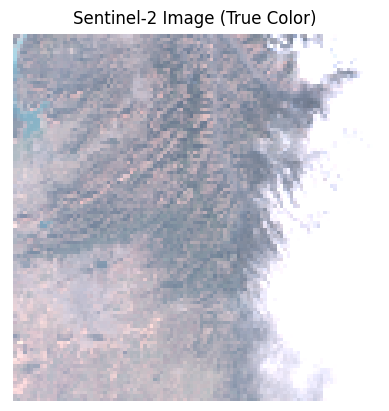

In [47]:
import ee
import cv2
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# Initialize Earth Engine (only required once)
ee.Initialize()

# Define region and time range
region = ee.Geometry.Point([73.0479, 33.6844])  # Example: Islamabad, Pakistan
start_date = '2025-01-01'
end_date = '2025-01-31'

# Fetch Sentinel-2 Image
sentinel2_dataset = ee.ImageCollection("COPERNICUS/S2") \
    .filterDate(start_date, end_date) \
    .filterBounds(region) \
    .select(['B4', 'B3', 'B2']) \
    .first()  # Get first image from collection

# Get Image URL
url = sentinel2_dataset.getThumbUrl({'min': 0, 'max': 3000, 'bands': ['B4', 'B3', 'B2'], 'scale': 1000})
print("Image URL:", url)

# Fetch and Display Image
response = requests.get(url, stream=True)  # Fetch the image
if response.status_code == 200:
    img = Image.open(BytesIO(response.content))  # Open image
    plt.imshow(img)
    plt.axis("off")  # Hide axes
    plt.title("Sentinel-2 Image (True Color)")
    plt.show()
else:
    print("Failed to fetch image!")


In [35]:
# Define a CNN Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Predict NO2 pollution level
])

# Compile Model
model.compile(optimizer='adam', loss='mse')

# Train Model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.0492 - val_loss: 18630.1328
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 14963.7148 - val_loss: 889.6545
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 753.6968 - val_loss: 0.2533
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.2173 - val_loss: 8.2636
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 6.2465 - val_loss: 0.5588
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.5336 - val_loss: 1.4899
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.3146 - val_loss: 1.5217
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.3402 - val_loss: 1.1961
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.0648 - val_loss: 0.7680
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.7002 - val_loss: 0.4024


In [37]:
y_pred = model.predict(X_test)

# Print some sample predictions vs. actual values
for i in range(5):  # Show first 5 results
    print(f"Predicted NO2: {y_pred[i][0]:.4f}, Actual NO2: {y_test[i][0]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Predicted NO2: 0.6043, Actual NO2: 0.0002
Predicted NO2: 0.7129, Actual NO2: 0.0001
Predicted NO2: 0.4720, Actual NO2: 0.0001
Predicted NO2: 0.5410, Actual NO2: 0.0002
Predicted NO2: 0.6740, Actual NO2: 0.0003


In [36]:
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.4024
Test Loss (MSE): 0.40244054794311523


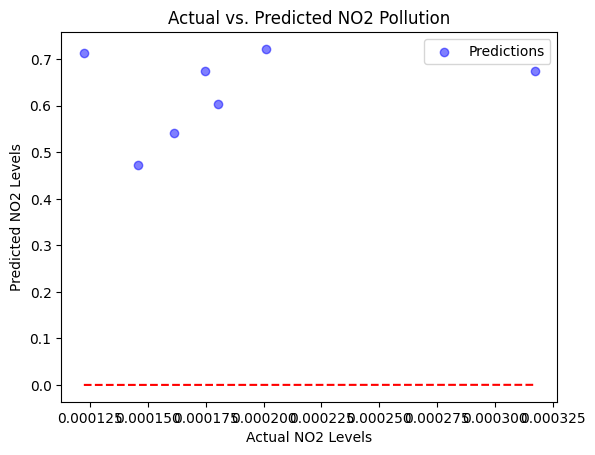

In [38]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle="dashed")  # Ideal fit line
plt.xlabel("Actual NO2 Levels")
plt.ylabel("Predicted NO2 Levels")
plt.legend()
plt.title("Actual vs. Predicted NO2 Pollution")
plt.show()
